In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

### Simulation

We use the same simulation from Tutorial 1 with a different propagation module.

In [17]:
def simulation(bB, mfp):
    sim = rw.Simulation()

    # source
    nr_particles = 10**2
    source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
    energy = 3*10**15 # eV
    source = rw.PointSourceIsotropicPhi(energy, source_pos, nr_particles)
    sim.add_source(source)

    # propagator
    nr_steps = 10**5
    step_size = 0.2*10**10 # [m]
    if bB == 0.0: #isotropic?
        propagator = rw.IsotropicPropagator(mfp, nr_steps, step_size)
    else:
        rms = 1 # Gaus
        magnetic_field = rw.OrderedBackgroundField(rms, [0,0,1]).magnetic_field
        propagator = rw.AnisotropicPropagator(magnetic_field, mfp, nr_steps, step_size)
    sim.add_propagator(propagator)

    # observer
    substeps = [False, False, True] # observe only steps (no substeps)
    min_step = 1
    max_step = nr_steps
    nr_obs_steps = 200
    observer = rw.TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)
    sim.add_observer(observer)

    # run simulation
    sim.run_simulation()
    sim.save_data('data/data_tut_4_bB_'+str(bB))

### Analysis

In [18]:
def plot_comparison(bB, seeds):
    df = pd.read_pickle("data/data_tut_4_bB_"+str(bB)+".pkl")
    sta = rw.Statistics(df)
    df_kappas = sta.plot_diffusion_coefficients(False, False, None)
    
    rwp_d = df_kappas['d'].tolist()
    rwp_kappa_perp = df_kappas['kappa_perp'].tolist()
    rwp_kappa_para = df_kappas['kappa_para'].tolist()

    ### load crpropa data
    crp_d = np.load('data/comparison/E_3e+16_bB_'+str(bB)+'_seeds_'+seeds+'_nr_20_d.npy')
    crp_kappa_perp = np.load('data/comparison/E_3e+16_bB_'+str(bB)+'_seeds_'+seeds+'_nr_20_kappa_perp.npy')
    crp_kappa_para = np.load('data/comparison/E_3e+16_bB_'+str(bB)+'_seeds_'+seeds+'_nr_20_kappa_para.npy')
    
    fig, ax1 = plt.subplots(figsize=(4,2.5))

    n_max = 10**4
    ax1.plot(crp_d[:n_max], np.array(crp_kappa_perp[:n_max])*10**4, label='$\kappa_\perp$ (EOM)', color='k')
    ax1.plot(crp_d[:n_max], np.array(crp_kappa_para[:n_max])*10**4, linestyle=':', label='$\kappa_\parallel$ (EOM)', color='k')
    ax1.plot(rwp_d, np.array(rwp_kappa_perp)*10**4, label='$\kappa_\perp$ (CRW)', color='brown')
    ax1.plot(rwp_d, np.array(rwp_kappa_para)*10**4, linestyle=':', label='$\kappa_\parallel$ (CRW)', color='brown')
    ax1.plot(crp_d[:n_max], np.ones(n_max)*np.mean(np.array(crp_kappa_perp[n_max-10:n_max]))*10**4, label='$\kappa_\perp$ (diffusive)', color='dodgerblue')
    ax1.plot(crp_d[:n_max], np.ones(n_max)*np.mean(np.array(crp_kappa_para[n_max-10:n_max]))*10**4, linestyle=':', label='$\kappa_\parallel$ (diffusive)', color='dodgerblue')


    ax1.set_xlabel('distance [m]')
    #ax1.axvline(x=mfp[1], c='grey', ls=':')
    #ax1.axvline(x=mfp[2], c='grey', ls='--')
    ax1.loglog()
    ax1.set_ylabel('$\kappa$ [cm$^2$/s]')

    #fig.legend()
    plt.savefig('kappas_bB_'+str(bB)+'.pdf')
    plt.show()

### Weak turbulence level b/B = 0.1

In [19]:
bB = 0.1
mfp = [3.75*10**13/2/2**0.5, 3.75*10**13/2/2**0.5, 7.2*10**13]
simulation(bB, mfp)

start simulation
Propagator initialized
Observer initialized


init statistics plotting class


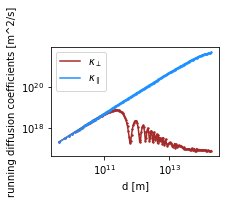

kappa_{xx}: 1.29e+18 m²/s +- 2.26e+18 m²/s
kappa_{yy}: 1.26e+18 m²/s +- 2.12e+18 m²/s
kappa_{zz}: 9.69e+20 m²/s +- 1.32e+21 m²/s


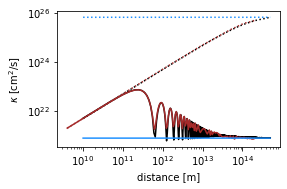

In [20]:
bB = 0.1
crpropa_seeds = '0_99'
plot_comparison(bB, crpropa_seeds)

### Intermediate turbulence level b/B = 0.5

In [21]:
bB = 0.5
diffusion_coefficient_perp = 1.0*10**18 # [m^2/s]
diffusion_coefficient_para = 1.4*10**20 # [m^2/s]
speed_of_light = 3*10**8 # [m/s]
mfp_perp = 3*diffusion_coefficient_para/speed_of_light
mfp_para = 3*diffusion_coefficient_para/speed_of_light
print(mfp_perp)
mfp = np.array([mfp_perp, mfp_perp, mfp_para], dtype=np.float32)  # [m]
#mfp = [2.*10**12/2**0.5, 2.*10**12/2**0.5, 2.1078*10**12] # [m]
simulation(bB, mfp)

1399999999999.9998
start simulation
Propagator initialized
Observer initialized


init statistics plotting class


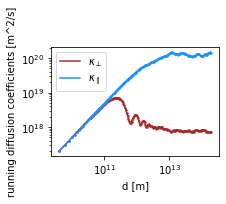

kappa_{xx}: 2.02e+18 m²/s +- 2.01e+18 m²/s
kappa_{yy}: 1.65e+18 m²/s +- 1.85e+18 m²/s
kappa_{zz}: 8.52e+19 m²/s +- 4.69e+19 m²/s


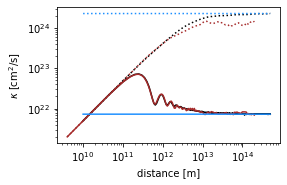

In [22]:
bB = 0.5
crpropa_seeds = '50_149'
plot_comparison(bB, crpropa_seeds)

### Strong turbulence level b/B = 20

In [8]:
bB = 0.0
mfp = [4.19*10**11, 4.19*10**11, 4.19*10**11]
simulation(bB, mfp)

start simulation
Propagator initialized
Observer initialized


init statistics plotting class


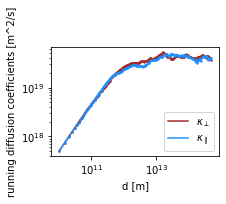

kappa_{xx}: 3.32e+19 m²/s +- 7.12e+18 m²/s
kappa_{yy}: 4.06e+19 m²/s +- 1.1e+19 m²/s
kappa_{zz}: 3.52e+19 m²/s +- 9.34e+18 m²/s


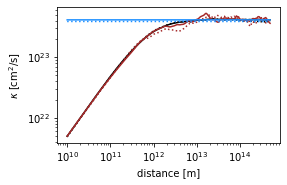

In [9]:
bB = 0.0
crpropa_seeds = '0_99'
plot_comparison(bB, crpropa_seeds)